# Momento de Retroalimentación: Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)

Julieta Itzel Pichardo Meza A01369630

**Descripción del Dataset**

El dataset que se usó en esta entrega tiene el nombre de student_performance_train, que fue descargado desde la plataforma de Hugging Face.

El dataset describe los hábitos y características que tienen una comunidad de estudiantes a los que pertenece este dataset. La métrica de rendimiento de los estudiantes es el GPA, que se mide en una escala de 0 a 4.0 en las escuelas donde se utiliza.

A continuación está la liga al repositorio donde se encuentra el dataset:

https://huggingface.co/datasets/navyakamath03/student_performance_train

Este repositorio no contiene una descripción oficial del dataset, pero las columnas se pueden interpretar de manera intuitiva.

Este dataset tiene un tamaño total de 1.33 GB, con un total de 8,000,774 filas. El dataset contiene 21 features: combinadas entre columnas numéricas y cadenas de caracteres.

La lista de features en el orden que aparecen en el dataset es el siguiente:

* Features numéricas:
  * Age
  * Grade
  * SES_Quartile
  * TestScore_Math
  * TestScore_Reading
  * TestScore_Science
  * GPA
  * AttendanceRate
  * StudyHours
  * InternetAcces
  * Extracurricular
  * PartTimeJob
  * ParentSupport
  * Romantic
  * FreeTime
  * GoOut

* Features de cadenas de caracteres:
  * Race
  * Gender
  * ParentalEducation
  * SchoolType
  * Locale






**Instalación y configuración del entorno**

Esta celda prepara el entorno de Google Colab. Instala Java (un requisito de Spark), descarga los binarios de Apache Spark, instala la librería pyspark de Python y, finalmente, configura las variables de entorno para que el sistema sepa dónde encontrar Java y Spark.

In [1]:
print("Instalando Java 11...")
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

print("Descargando Spark 3.3.2...")
# Usamos el archivo oficial de Apache en lugar de SourceForge
!wget -q --show-progress https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

print("Descomprimiendo Spark...")
!tar xf spark-3.3.2-bin-hadoop3.tgz

print("Instalando findspark (útil para Colab) y pyspark")
!pip install -q findspark pyspark

print("Configurando variables de entorno...")
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
os.environ["PATH"] += f":{os.environ['SPARK_HOME']}/bin:{os.environ['JAVA_HOME']}/bin"

# Inicializar findspark para que la sesión de Colab encuentre Spark
import findspark
findspark.init()

# Prueba para verificar que funciona
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("PruebaSpark").getOrCreate()

print(f"✅ Entorno Spark listo. Versión: {spark.version}")
spark.stop()

Instalando Java 11...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Descargando Spark 3.3.2...
spark-3.3.2-bin-had 100%[===================>] 285.49M  23.6MB/s    in 12s     
Descomprimiendo Spark...
Instalando findspark (útil para Colab) y pyspark
Configurando variables de entorno...
✅ Entorno Spark listo. Versión: 3.3.2


**Inicio de Spark e Importaciones**

Aquí, se importan todas las librerías necesarias para el análisis (PySpark, Pandas, Seaborn). Lo más importante es que crea e inicia la SparkSession, que es el objeto principal y el punto de entrada para poder usar toda la funcionalidad de Spark en nuestro script.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Crear la SparkSession
spark = SparkSession.builder.appName('Proyecto_EDA_Regresion').getOrCreate()

print("SparkSession iniciada.")
print(f"Versión de Spark: {spark.version}")

SparkSession iniciada.
Versión de Spark: 3.3.2


**Carga y Exploración Inicial**

Esta celda descarga el archivo CSV original y lo carga en un DataFrame de Spark. Inmediatamente después, realiza un primer Análisis Exploratorio de Datos mostrando el esquema (tipos de datos), las primeras filas y un resumen estadístico (.describe()) de las columnas numéricas.

In [3]:
# Descargar el dataset
if not os.path.exists("student_performance_train.csv"):
    print("Descargando dataset...")
    !wget -q https://huggingface.co/datasets/navyakamath03/student_performance_train/resolve/main/student_performance_train.csv -O student_performance_train.csv

print("Cargando datos en DataFrame de Spark...")
df_total = spark.read.csv("student_performance_train.csv", header=True, inferSchema=True)

print("\n--- Schema del DataFrame Original ---")
df_total.printSchema()

print("\n--- Muestra del DataFrame Original ---")
df_total.show(5, truncate=False)

print("\n--- Estadísticas Descriptivas (Columnas Numéricas) ---")

df_total.describe().show()

Descargando dataset...
Cargando datos en DataFrame de Spark...

--- Schema del DataFrame Original ---
root
 |-- Age: integer (nullable = true)
 |-- Grade: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- SES_Quartile: integer (nullable = true)
 |-- ParentalEducation: string (nullable = true)
 |-- SchoolType: string (nullable = true)
 |-- Locale: string (nullable = true)
 |-- TestScore_Math: double (nullable = true)
 |-- TestScore_Reading: double (nullable = true)
 |-- TestScore_Science: double (nullable = true)
 |-- GPA: double (nullable = true)
 |-- AttendanceRate: double (nullable = true)
 |-- StudyHours: double (nullable = true)
 |-- InternetAccess: integer (nullable = true)
 |-- Extracurricular: integer (nullable = true)
 |-- PartTimeJob: integer (nullable = true)
 |-- ParentSupport: integer (nullable = true)
 |-- Romantic: integer (nullable = true)
 |-- FreeTime: integer (nullable = true)
 |-- GoOut: integer (nullable = true)

**Matriz de Correlación**

Esta celda profundiza el EDA. Agrupa todas las variables numéricas en un vector, calcula la matriz de correlación de Pearson para ver qué tan fuerte (de -1 a 1) se relacionan las variables entre sí, y finalmente usa Seaborn para visualizar esta matriz como un mapa de calor (heatmap) fácil de interpretar.

**Interpretación de la matriz de correlación**

Para elegir las variables independientes que va a usar el modelo de regresión lineal múltiple, se hace una matriz de correlación entre todas las variables numéricas y la variable de interés a predecir, que en este caso es "GPA".

Al examinal la matriz, se puede observa que las variables con un mayor valor de correlación son las siguientes, listadas de mayor a menor valor numérico:
* AttendanceRate (0.70)
* TestScore_Math (0.68)
* TestScore_Reading (0.68)
* TestScore_Science (0.68)
* StudyHours (0.39)

Analizando los resultados, es una buena desición usar las primeras cuatro variables para el modelo de regresión lineal múltiple.


--- Matriz de Correlación (Heatmap) ---


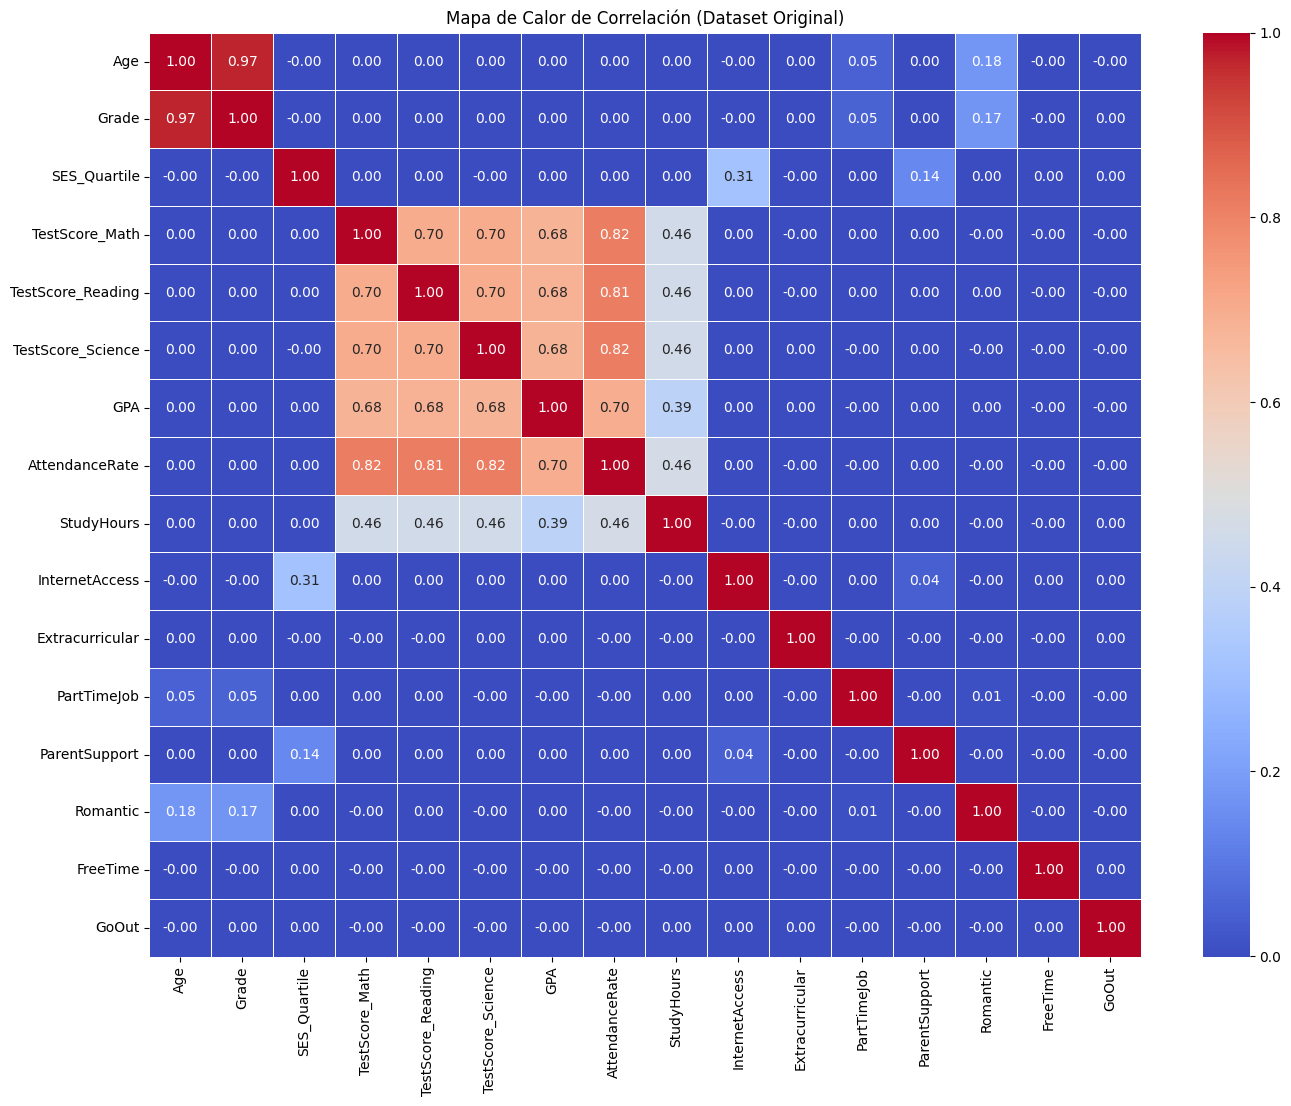

In [4]:
# Lista de todas las columnas numéricas del dataset original
numeric_cols = [
    "Age", "Grade", "SES_Quartile",
    "TestScore_Math", "TestScore_Reading", "TestScore_Science",
    "GPA", "AttendanceRate", "StudyHours",
    "InternetAccess", "Extracurricular", "PartTimeJob",
    "ParentSupport", "Romantic", "FreeTime", "GoOut"
]

# 1. Ensamblar las columnas en un vector
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features",
    handleInvalid="skip" # Omitir filas con nulos
)
df_vector = assembler.transform(df_total).select("features")

# 2. Calcular la matriz de correlación de Pearson
matrix_row = Correlation.corr(df_vector, "features").head()
corr_matrix = matrix_row[0].toArray()

# 3. Convertir a Pandas DataFrame para visualización
df_corr_pd = pd.DataFrame(corr_matrix, columns=numeric_cols, index=numeric_cols)

# 4. Visualizar la matriz como un Heatmap
print("\n--- Matriz de Correlación (Heatmap) ---")
plt.figure(figsize=(16, 12))
sns.heatmap(df_corr_pd, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title("Mapa de Calor de Correlación (Dataset Original)")
plt.show()

**Selección de Datos para el Modelo**

A partir del DataFrame completo, esta celda crea un nuevo DataFrame (df_modelo) más pequeño y enfocado. Selecciona únicamente las 5 columnas que usaremos para el modelo (las 4 predictoras y la objetivo, GPA) y elimina cualquier fila que tenga valores nulos (na.drop()) para asegurar un conjunto de datos limpio.

In [5]:
# Lista de las columnas específicas que queremos para el modelo
columnas_modelo = [
    "AttendanceRate",
    "TestScore_Math",
    "TestScore_Reading",
    "TestScore_Science",
    "GPA" # Nuestra variable objetivo (label)
]

# Crear el DataFrame de trabajo final
df_modelo = df_total.select(columnas_modelo).na.drop() # Eliminamos filas con nulos

print(f"DataFrame original tenía {df_total.count()} filas.")
print(f"DataFrame para modelo (sin nulos) tiene {df_modelo.count()} filas.")

print("\nSchema del DataFrame para el Modelo:")
df_modelo.printSchema()

print("\nMuestra del DataFrame para el Modelo:")
df_modelo.show(5)

DataFrame original tenía 8000774 filas.
DataFrame para modelo (sin nulos) tiene 8000774 filas.

Schema del DataFrame para el Modelo:
root
 |-- AttendanceRate: double (nullable = true)
 |-- TestScore_Math: double (nullable = true)
 |-- TestScore_Reading: double (nullable = true)
 |-- TestScore_Science: double (nullable = true)
 |-- GPA: double (nullable = true)


Muestra del DataFrame para el Modelo:
+------------------+-----------------+-----------------+------------------+------------------+
|    AttendanceRate|   TestScore_Math|TestScore_Reading| TestScore_Science|               GPA|
+------------------+-----------------+-----------------+------------------+------------------+
|0.9068087184509344|70.25823548338548| 79.6651847035797| 80.82422979723856| 2.743878869423204|
|0.8437393636912216|67.87654582366186|59.61150524668959|  70.9203406993295| 2.587699661565628|
|0.8509229819097245|62.07062325793374|70.57744321423539|60.624018354069534| 2.426293516645388|
|0.9467861905219864|79.9093

**Definición del Pipeline de Machine Learning**

Esta celda define la "receta" del modelo de Machine Learning usando un Pipeline. Encapsula una secuencia de tres pasos: 1) VectorAssembler (agrupa las 4 features), 2) StandardScaler (estandariza esas features para que tengan la misma escala), y 3) LinearRegression (el algoritmo que predecirá el GPA). Este objeto es el plano del modelo que aún no ha sido entrenado.

In [6]:
# 1. Definir las columnas de características (X) y la etiqueta (y)
feature_cols = [
    "AttendanceRate",
    "TestScore_Math",
    "TestScore_Reading",
    "TestScore_Science"
]

# 2. Etapa 1: Ensamblar las características en un vector "features"
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# 3. Etapa 2: Estandarizar las características (media=0, std=1)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True
)

# 4. Etapa 3: Definir el modelo de Regresión Lineal
# Usamos las features escaladas y predecimos la columna GPA
lr = LinearRegression(
    featuresCol="scaledFeatures",
    labelCol="GPA"
)

# 5. Encapsular todas las etapas en un Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

print("Pipeline de ML definido con 3 etapas: assembler, scaler, lr.")

Pipeline de ML definido con 3 etapas: assembler, scaler, lr.


**División y Entrenamiento**

Esta celda realiza dos acciones clave: primero, divide los datos del modelo en dos conjuntos: training_data (80% para entrenar) y test_data (20% para evaluar). Segundo, usa el comando .fit() sobre los datos de entrenamiento para ejecutar el pipeline definido en la celda anterior, creando así el modelo ya entrenado (pipeline_model).

In [7]:
# Dividir los datos: 80% entrenamiento, 20% prueba
(training_data, test_data) = df_modelo.randomSplit([0.8, 0.2], seed=42)

print("Datos divididos:")
print(f"Filas de Entrenamiento: {training_data.count()}")
print(f"Filas de Prueba: {test_data.count()}")

# Entrenar el pipeline completo con los datos de entrenamiento
print("\nEntrenando el pipeline...")
pipeline_model = pipeline.fit(training_data)

print("¡Modelo entrenado exitosamente!")

Datos divididos:
Filas de Entrenamiento: 6400266
Filas de Prueba: 1600508

Entrenando el pipeline...
¡Modelo entrenado exitosamente!


**Evaluación del Modelo e interpretación de coeficientes**

Aquí se pone a prueba el modelo. Se usa el pipeline_model entrenado para hacer predicciones sobre el conjunto de test_data (datos que nunca antes vio). Luego, usa RegressionEvaluator para comparar las predicciones con los valores reales (GPA) y calcular las métricas clave: $R^2$ (qué tan bien explica la varianza) y $RMSE$ (cuál es el error promedio de la predicción).

La celda final nos permite "abrir" el modelo para entender cómo funciona. Extrae y muestra el intercepto (el valor base del GPA) y los coeficientes (los pesos) que el modelo asignó a cada variable. Esto nos dice qué variables son más importantes y si su impacto en el GPA es positivo o negativo.

**Interpretación de los resultados de la celda 8**

* Intercepto `2.9968`

Si un estudiante que tuviera un desempeño perfectamente promedio en todas las variables (asistencia promedio, nota promedio en matemáticas, etc.) tendría un GPA predicho de `2.9968`.

* Coeficientes:

TestScore_Math: 0.130486

TestScore_Reading: 0.130424

TestScore_Science: 0.130390

En esta ejecución del modelo, el algoritmo ha concluido que las tres asignaturas tienen prácticamente el mismo peso e importancia. El modelo considera que un aumento de 1 desviación estándar en Matemáticas es casi idéntico a un aumento de 1 desviación estándar en Ciencias o Lectura. Todas contribuyen positivamente y casi por igual.

AttendanceRate: 0.001331

Este coeficiente es extremadamente pequeño, es funcionalmente cero. El modelo, basándose en los datos de entrenamiento que recibió, ha decidido que la Tasa de Asistencia no tiene ningún impacto estadístico real en el GPA. Es tan insignificante que el modelo lo está ignorando.

**Interpretando las métricas de evaluación**

El modelo explica más de la mitad (58.35%) de por qué el GPA de los estudiantes cambia. Demuestra que las notas y la asistencia tienen una relación estadística significativa y predecible con el GPA.

Queda un 41.65% del vaso "vacío". Esto es la varianza no explicada. Significa que hay otros factores que no están en tu modelo (talvez las horas de estudio, el apoyo de los padres, el nivel socioeconómico, etc.) que también influyen en el GPA.

El modelo se equivoca, en promedio, por ± 0.2964 puntos de GPA (dado el error RMSE).


En conclusión, el modelo tiene un poder predictivo moderado (explica el 58.35% del comportamiento del GPA) y sus predicciones son razonablemente precisas, equivocándose en promedio por solo ~0.30 puntos en la escala de GPA.

In [8]:
print("Evaluando el modelo con los datos de prueba...")

# 1. Hacer predicciones
predictions = pipeline_model.transform(test_data)

print("\nMuestra de predicciones (Label vs. Predicción):")
predictions.select(
    col("GPA").alias("Label_Real"),
    col("prediction").alias("Prediccion_Modelo")
).show(10)

# 2. Evaluar con R-squared (R²)
evaluator_r2 = RegressionEvaluator(
    labelCol="GPA",
    predictionCol="prediction",
    metricName="r2"
)
r2 = evaluator_r2.evaluate(predictions)
print(f"\n--- Métricas de Evaluación ---")
print(f"R-squared (R²): {r2:.4f}")

# 3. Evaluar con Root Mean Squared Error (RMSE)
evaluator_rmse = RegressionEvaluator(
    labelCol="GPA",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Evaluando el modelo con los datos de prueba...

Muestra de predicciones (Label vs. Predicción):
+------------------+------------------+
|        Label_Real| Prediccion_Modelo|
+------------------+------------------+
| 1.222708421648894| 1.404886988707959|
|1.7525608497232747|1.5761605790680497|
|1.7524949087275172|1.6570995437406715|
|1.2100617237251383|1.7556842845598952|
|  2.02092632260293|1.7719651458433492|
|1.8002453857375895|1.8128320544519745|
|1.4989344722481703| 1.755112341861577|
|1.3232446795650517|1.6860434848568906|
|1.9162846306388617|1.8021180378796164|
|1.4387582630206233|1.6890256074110017|
+------------------+------------------+
only showing top 10 rows


--- Métricas de Evaluación ---
R-squared (R²): 0.5835
Root Mean Squared Error (RMSE): 0.2964


In [9]:

print("--- Coeficientes del Modelo ---")

# El modelo de regresión (lr) es la última etapa (índice 2) de nuestro pipeline
lr_model = pipeline_model.stages[-1] # stages[-1] es una forma robusta de tomar la última etapa

# Obtener el Intercepto
print(f"\nIntercepto (Valor base del GPA): {lr_model.intercept:.4f}")

# Mapear los coeficientes a los nombres de las features
coeficientes = lr_model.coefficients
feature_weights = pd.DataFrame({
    'Variable': feature_cols,
    'Coeficiente (Peso)': coeficientes
})
feature_weights = feature_weights.sort_values(by="Coeficiente (Peso)", ascending=False)

print("\nPesos de las variables (Coeficientes):")
display(feature_weights)



--- Coeficientes del Modelo ---

Intercepto (Valor base del GPA): 2.9968

Pesos de las variables (Coeficientes):


,Variable,Coeficiente (Peso)
1,TestScore_Math,0.130486
2,TestScore_Reading,0.130424
3,TestScore_Science,0.130390
0,AttendanceRate,0.001331


### Conclusiones y puntos a mejorar

El modelo tiene un buen poder predictivo (`58.35%`), pero podría mejorar para tener un mejor accuracy.

Esto se podría hacer eligiendo más features que no sean numéricas que sean parte de este dataset en el modelo como el tipo de escuela a la que atienden los alumnos, el nivel educativo de los padres; además de incluir más variables numéricas como el número de horas de estudio/tiempo libre, o si tienen un un trabajo de medio tiempo o a cuántas actividades extracurriculares están inscritos.

En cuanto a mejoras del código, se puede implementar K-fold validation en vez de tener un solo conjunto de train y test para entrenar el modelo de manera más robusta.



## Tablero y visualización de datos

Para visualizar los datos del dataset mencionado, se crearon varias gráficas y KPIs para tener un mejor entendimiento de cómo interactuaban los datos entre sí.

A continuación, se muestran las gráficas y su interpretación.

**KPIs del datset**

En la siguiente imagen se puede ver la parte superior del tablero, en donde se muestran las estadísticas de KPI del dataset trabajado.

En ella se pueden ver cuatro diferentes KPI: Promedio GPA, Promedio de Asistencia (en porcentaje), Promedio de Test Score Math y Promedio de Edad de los Estudiantes.

Se eligieron estas estadísticas ya que forman parte importante del análisis y modelo de predicción que se implementó en esta entrega.

* El valor del promedio de GPA es de 2.997, en una escala de 0 a 4.
* El valor del promedio de asistencia es de 89% (ya convirtiéndolo a porcentaje).
* El valor del promedio de Test Score Math es de 74.98, en una escala de 0 a 100.
* El valor del promedio de edad dentro de los estudiantes es de 16 años.

Dentro de estas KPIs, se encuentran algunas de las features que se usaron en el modelo, por lo que sí es conveniente visualizar estas métricas en el tablero.


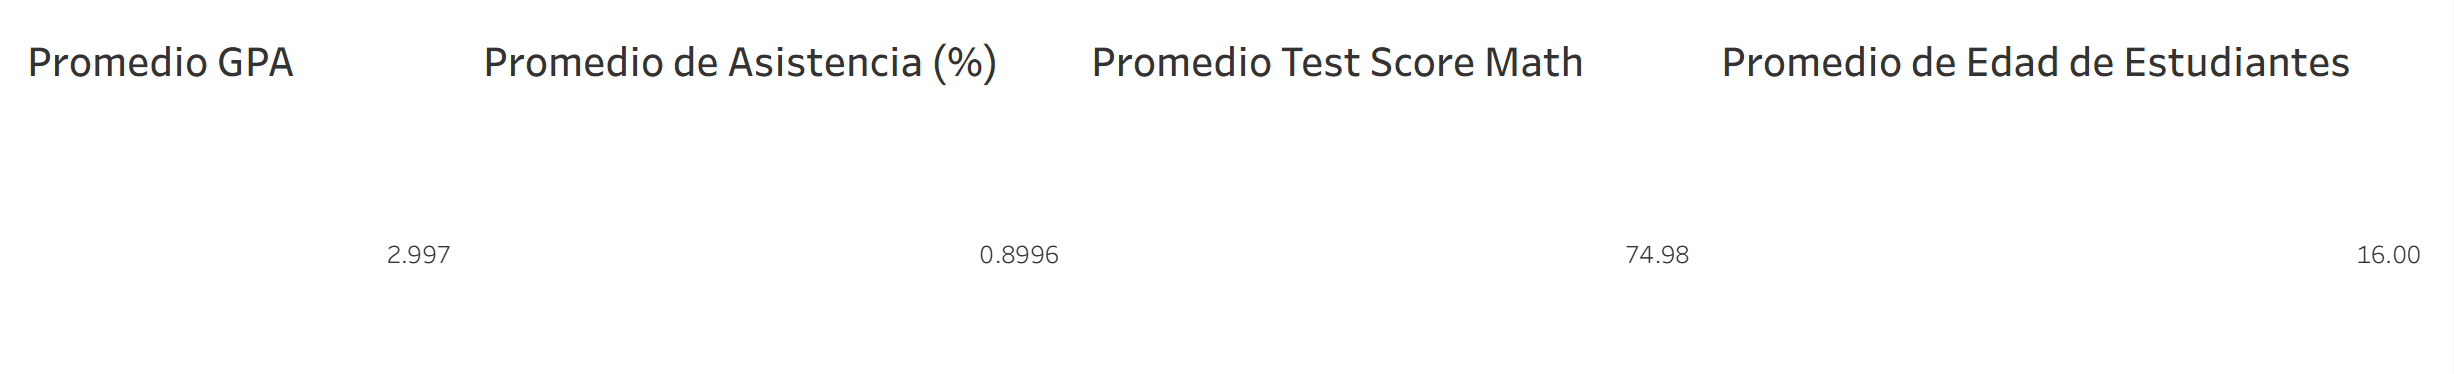

**Gráficas descriptivas**



En la parte de las gráficas se encuentran dos:
* Una que muestra la distribución de las puntuaciones de GPA de los estudiantes en el dataset.
* Otra que muestra el promedio de horas libres agrupadas por género.

En la primera se puede ver como la distribución de los valores del GPA de los alumnos; el eje y mide cuántas filas contienen el valor del GPA indicado por el eje x. Cabe mencionar que la distribución que reveló la gráfica es normal.

En la segunda gráfica se muestra el promedio de horas que cada género invierte en estudiar. En la etiqueta se muestra que para ambos géneros el promedio de horas es similar.

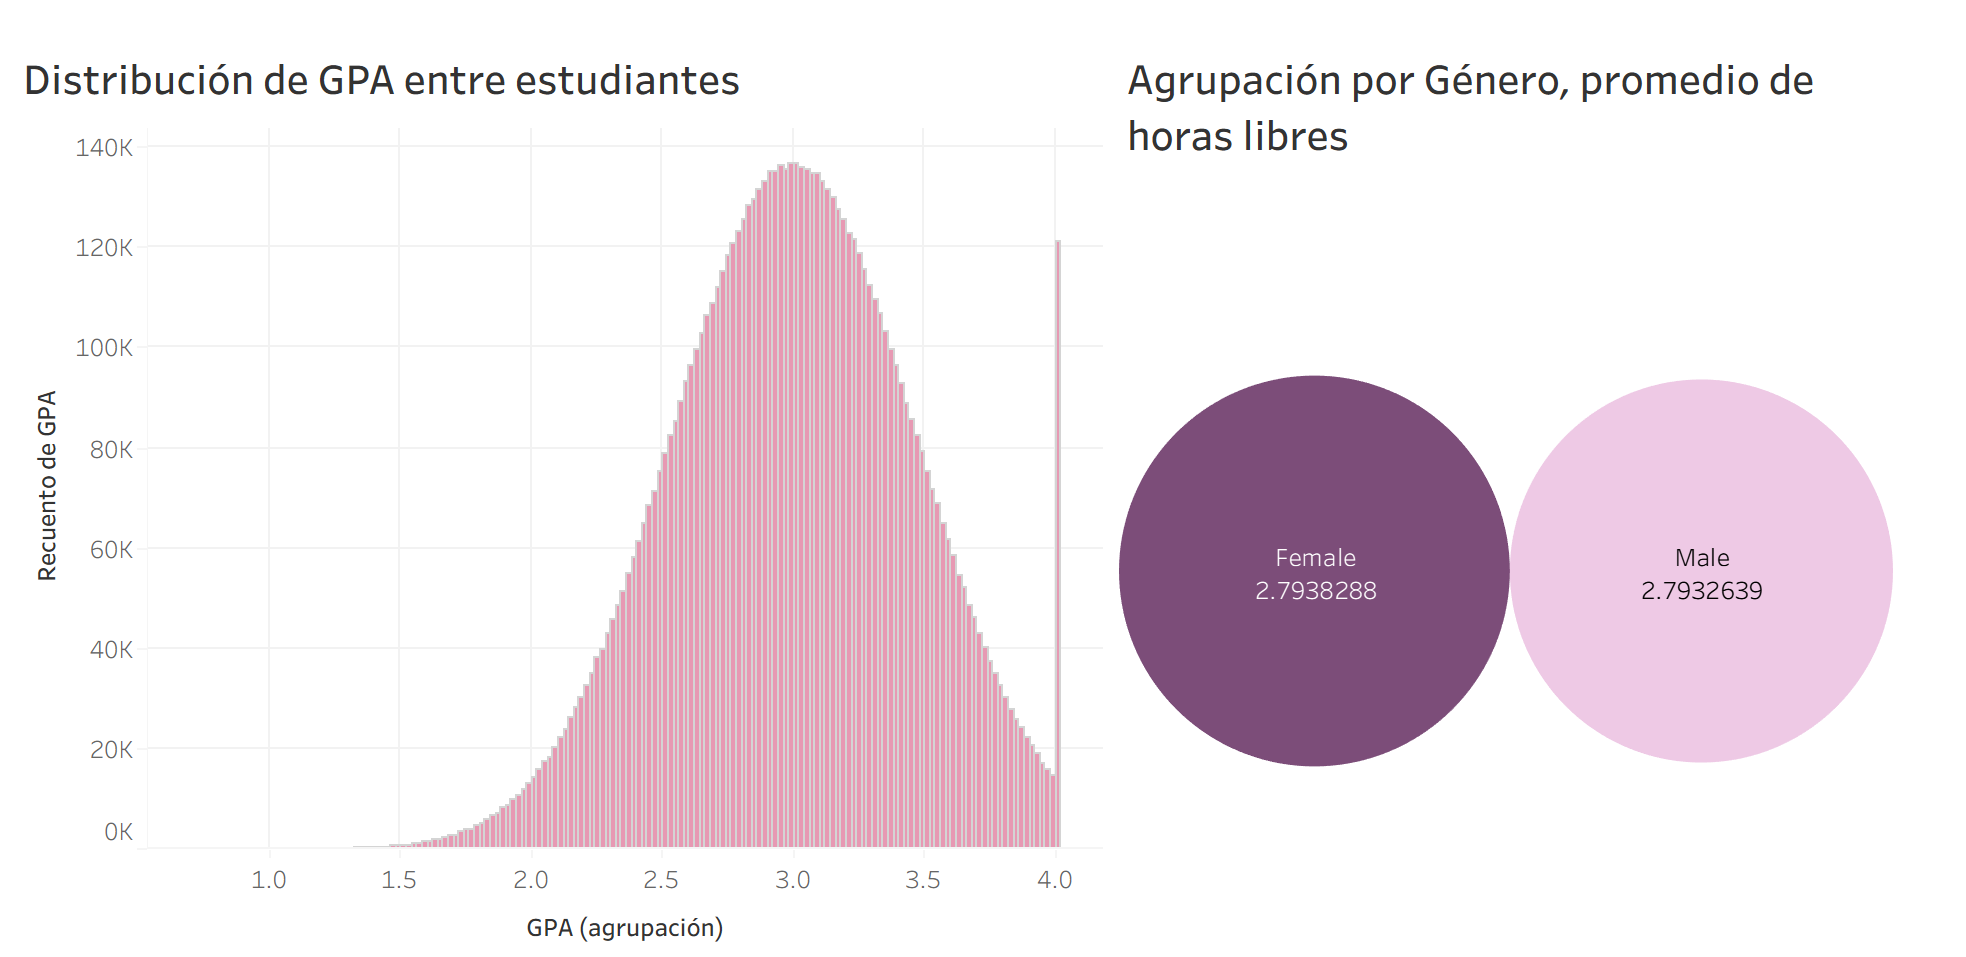